# Fantasy Premier League (FPL) Advisor Neural Network Model Builder

The purpose of this notebook is to train a neural network that can predict the expected points for specific player and fixture combination. Currently, the training data is based on [fpl-data](https://github.com/177arc/fpl-data) which contains a rolling window of fixtures from this and the past season.

# Installation
To get started, run the following command to install all required dependencies.

In [ ]:
#!pip install -q -r requirements.txt
!pip install -q -r requirements_nn.txt

# Import requirements
Here we import all external and local modulues.

In [ ]:
import pandas as pd, os, sys
from fplpandas import FPLPandas
from datadict.jupyter import DataDict

import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import matplotlib.pyplot as plt

# Load local modules
sys.path.append(os.getcwd())
from data import get_df
from nn import *

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

# Set variables
This section sets all important global variables.

In [ ]:
data_url = 'http://fpl.177arc.net.s3.eu-west-2.amazonaws.com/v1/latest/'

# Load pre-processed data
This section loads data sets generated by the [fpl-data](https://github.com/177arc/fpl-data) lambda function and made available via the S3 bucket specified in the `data_url` variable.

In [ ]:
players_fixture_team_eps_ext = get_df(url=f'{data_url}players_gw_team_eps_ext.csv', index=['Player Code', 'Season', 'Game Week'])
players_fixture_team_eps_ext.head(5)

## Create training and test datasets 

In [41]:
train_df, test_df = (players_fixture_team_eps_ext
    .reset_index()
    [lambda df: df['Fixture Minutes Played'] > 0]
    .assign(**{'Is Home?': lambda df: df['Is Home?'].astype(int)})
#[['Fixture Total Points']].assign(**{'Total Points': lambda df: df['Fixture Total Points']})
#[['Fixture Total Points', 'Player Code']]
#[['Fixture Total Points', 'Field Position', 'Total Points To Fixture', 'Fixtures Played To Fixture', 'Opp Team FDR']]
[['Fixture Total Points', 'Fixtures Played To Fixture', 'Fixture Cost', 'Field Position', 'Team Strength', 'Is Home?', 'Expected Goals For', 'Expected Goals Against', 'Opp Team FDR']]
    .dropna(how='any', axis=0)
    .pipe(nn_split, frac=0.8))
train_ds = train_df.pipe(nn_prep_ds, 'Fixture Total Points')
test_ds = test_df.pipe(nn_prep_ds, 'Fixture Total Points')

## Create feature columns

In [42]:
feature_columns_cats = {'field_position': ['GK', 'DEF', 'MID', 'FWD']}

feature_columns = []
for col, spec in train_ds.element_spec[0].items():
    if spec.dtype in [tf.bool, tf.float64]:
        feature_columns.append(feature_column.numeric_column(col))
        
    if col in feature_columns_cats.keys():
        field_pos = feature_column.categorical_column_with_vocabulary_list(col, feature_columns_cats[col])
        field_pos_one_hot = feature_column.indicator_column(field_pos)
        feature_columns.append(field_pos_one_hot)        

## Create model
Here we create a neural network with four layers. Although ultimately the mean 

In [43]:
model = tf.keras.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns, dtype='float64'),
  layers.Dense(100, activation='relu', dtype='float64'),
  layers.Dense(6, activation='relu', dtype='float64'),
  layers.Dense(1, dtype='float64')
])

model.compile(loss='mse',
                optimizer=tf.keras.optimizers.RMSprop(0.001),
                metrics=['mse', 'mae'])

## Train model

In [44]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

train_history = model.fit(train_ds,
          validation_data=test_ds,
          epochs=60,
          callbacks=[early_stop])

Epoch 1/60
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
240/259 [==========================>...] - ETA: 0s - loss: 10.4532 - mse: 10.4532 - mae: 2.1847WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'fixtures_played_to_fixture': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'fixture_cost': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'field_position': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'team_strength': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'is_home_': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float64>, 'expected_goals_for': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'expected_goals_against': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'opp_team_fdr': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>}
Consider rewriting thi

259/259 [==============================] - 1s 2ms/step - loss: 8.4892 - mse: 8.4892 - mae: 2.1230 - val_loss: 9.1900 - val_mse: 9.1900 - val_mae: 2.1924
Epoch 36/60
259/259 [==============================] - 1s 2ms/step - loss: 8.4845 - mse: 8.4845 - mae: 2.1226 - val_loss: 9.1908 - val_mse: 9.1908 - val_mae: 2.1932
Epoch 37/60
259/259 [==============================] - 1s 2ms/step - loss: 8.4782 - mse: 8.4782 - mae: 2.1217 - val_loss: 9.2018 - val_mse: 9.2018 - val_mae: 2.1949
Epoch 38/60
259/259 [==============================] - 1s 2ms/step - loss: 8.4748 - mse: 8.4748 - mae: 2.1214 - val_loss: 9.1948 - val_mse: 9.1948 - val_mae: 2.1952
Epoch 39/60
259/259 [==============================] - 1s 2ms/step - loss: 8.4702 - mse: 8.4702 - mae: 2.1202 - val_loss: 9.1975 - val_mse: 9.1975 - val_mae: 2.1950
Epoch 40/60
259/259 [==============================] - 1s 2ms/step - loss: 8.4658 - mse: 8.4658 - mae: 2.1191 - val_loss: 9.2058 - val_mse: 9.2058 - val_mae: 2.1937
Epoch 41/60
259/259 [=

## Evaluate model

Text(0,0.5,'MSE [Fixture]')

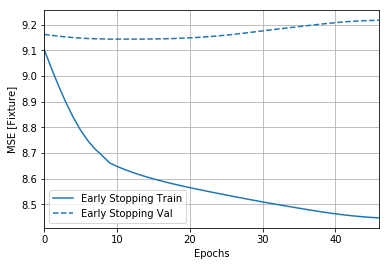

In [45]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Early Stopping': train_history}, metric = 'mse')
plt.ylabel('MSE [Fixture]')

Consider rewriting this model with the Functional API.


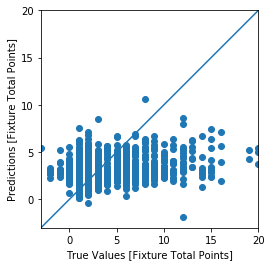

In [46]:
test_predictions = model.predict(test_ds).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_df['Fixture Total Points'], test_predictions)
plt.xlabel('True Values [Fixture Total Points]')
plt.ylabel('Predictions [Fixture Total Points]')
lims = [-3, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
test_df['Predicted'] = test_predictions
test_df

## Save model

In [ ]:
model.save('models/expected_points')